In [1]:
import pandas as pd
import xarray as xr
from glob import glob
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from utils.cmod5n import cmod5n_forward, cmod5n_inverse

In [2]:
df = pd.read_parquet("processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("processed_data/wv2_complete.parquet")

In [3]:
df.path_to_sar_file.str.replace("/projects/fluxsar/data/", "processed_data/")

172       processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...
174       processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...
414       processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...
416       processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...
540       processed_data/Sentinel1/WV/2021/S1A_WV_SLC__1...
                                ...                        
720624    processed_data/Sentinel1/WV/2020/S1A_WV_SLC__1...
720626    processed_data/Sentinel1/WV/2020/S1A_WV_SLC__1...
720628    processed_data/Sentinel1/WV/2020/S1A_WV_SLC__1...
720634    processed_data/Sentinel1/WV/2020/S1A_WV_SLC__1...
720636    processed_data/Sentinel1/WV/2020/S1A_WV_SLC__1...
Name: path_to_sar_file, Length: 36921, dtype: object

(195, 205)


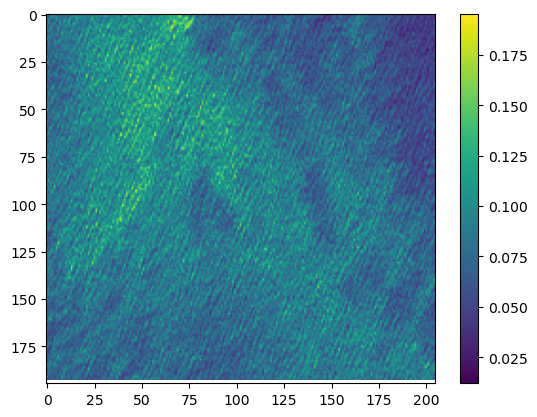

In [4]:
data_path = Path("processed_data/Sentinel1/WV/2020")
datasets_list = sorted(glob(f"{data_path}/*.nc"))

ds = xr.open_dataset(datasets_list[0])
sigma0 = ds.sigma0[0].values
ground_heading = ds.ground_heading[0].values
azimuth_look = np.mod(ground_heading, 360)


plt.imshow(sigma0)
plt.colorbar()
print(sigma0.shape)

# ds = xr.open_dataset(data_path[0])

In [5]:
datasets_list[0].split("\\")[-1]

row = df2[df2.renamed_filename == datasets_list[0].split("\\")[-1]]

v = row.wspd.values[0]
wdir_deg_from_north = row.wdir_deg_from_north.values[0]




In [6]:
for v in ds.data_vars:
    print(v)

time
land_mask
ground_heading
sigma0_raw
nesz
incidence
longitude
latitude
sigma0


In [7]:
print(f"original sigma0 shape: {sigma0.shape}")
sigma0 = sigma0[~np.isnan(sigma0).any(axis=1)]

# Remove columns with NaNs
sigma0 = sigma0[:, ~np.isnan(sigma0).any(axis=0)]
print(f"new sigma0 shape: {sigma0.shape}")

original sigma0 shape: (195, 205)
new sigma0 shape: (194, 205)


Text(0, 0.5, 'Spatial Frequency (v)')

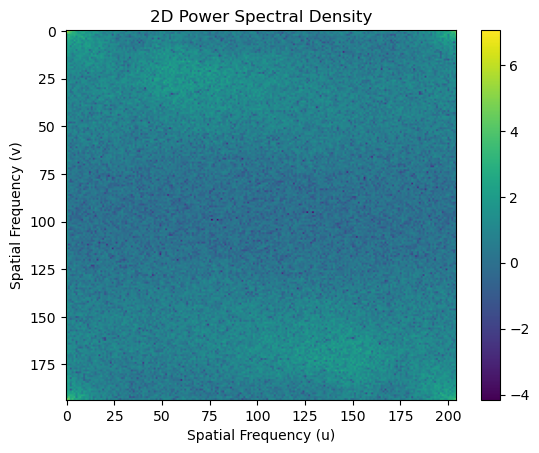

In [8]:
fft_data = np.fft.fft2(sigma0)
psd2d = np.abs(fft_data) ** 2

plt.imshow(np.log10(psd2d))
plt.colorbar()
plt.title("2D Power Spectral Density")

# fill axis legends

plt.xlabel("Spatial Frequency (u)")
plt.ylabel("Spatial Frequency (v)")

In [9]:
ds.sigma0.values[0]
ds.ground_heading.values

array([[-10.406447, -10.406412, -10.406378, ..., -10.399477, -10.399443,
        -10.399408],
       [-10.406257, -10.406222, -10.406187, ..., -10.399286, -10.399252,
        -10.399218],
       [-10.406066, -10.406032, -10.405997, ..., -10.399096, -10.399061,
        -10.399027],
       ...,
       [-10.369808, -10.369774, -10.36974 , ..., -10.36282 , -10.362785,
        -10.362751],
       [-10.369617, -10.369583, -10.369548, ..., -10.362629, -10.362594,
        -10.362559],
       [-10.369426, -10.369391, -10.369357, ..., -10.362437, -10.362403,
        -10.362369]], dtype=float32)

In [10]:
df = pd.read_parquet("results/wv1_results.parquet")

In [11]:
df.columns

Index(['sar_filepath', 'era5_wspd', 'era5_wdir', 'wspd_perturbed',
       'wdir_perturbed', 'phi_perturbed', 'phi_nominal', 'sigma_sar_median',
       'sigma_cmod_median', 'band0_wspd_mean', 'band0_wspd_median',
       'band1_wspd_mean', 'band1_wspd_median', 'band2_wspd_mean',
       'band2_wspd_median', 'errors_band0', 'errors_band1', 'errors_band2',
       'kw_statistic', 'kw_p_value', 'is_scale_dependent'],
      dtype='object')

In [12]:
df.head().iloc[:, 1:]

,era5_wspd,era5_wdir,wspd_perturbed,wdir_perturbed,phi_perturbed,phi_nominal,sigma_sar_median,sigma_cmod_median,band0_wspd_mean,band0_wspd_median,band1_wspd_mean,band1_wspd_median,band2_wspd_mean,band2_wspd_median,errors_band0,errors_band1,errors_band2,kw_statistic,kw_p_value,is_scale_dependent
0,17.090385,98.803959,18.198870,97.220168,27.919204,29.502991,0.662777,0.698000,17.663506,17.695312,0.631508,-0.039062,1.032125,-0.039062,"{'abs_error': 0.8905325801018824, 'bias': 0.57...","{'abs_error': 16.458876907984006, 'bias': -16....","{'abs_error': 16.05825962954367, 'bias': -16.0...",87494.601144,0.0,True
1,15.270632,51.500500,16.062753,49.790906,128.033033,129.742615,0.416609,0.406072,16.055116,16.289062,0.597744,-0.039062,0.863546,-0.039062,"{'abs_error': 1.533460512401759, 'bias': 0.784...","{'abs_error': 14.672887592508475, 'bias': -14....","{'abs_error': 14.407085714218764, 'bias': -14....",86617.668582,0.0,True
2,20.294914,57.751923,21.960506,56.389668,-13.418178,-12.055923,0.819972,0.895996,20.102296,20.117188,1.490900,-0.039062,2.304854,-0.039062,"{'abs_error': 1.0888723951158272, 'bias': -0.1...","{'abs_error': 18.804014087640347, 'bias': -18....","{'abs_error': 17.992506156402484, 'bias': -17....",87904.507585,0.0,True
3,15.088510,90.745164,15.848969,89.022980,161.294586,163.016785,0.555867,0.681719,13.091840,13.164062,0.532245,-0.039062,0.948725,-0.039062,"{'abs_error': 2.014473580359198, 'bias': -1.99...","{'abs_error': 14.55626572392356, 'bias': -14.5...","{'abs_error': 14.139785540294733, 'bias': -14....",90609.138957,0.0,True
4,18.235678,21.681997,19.543272,20.177382,84.040847,85.545471,0.280104,0.428899,10.925962,10.820312,0.236181,-0.039062,0.288325,-0.039062,"{'abs_error': 7.309995687059638, 'bias': -7.30...","{'abs_error': 17.99949693276537, 'bias': -17.9...","{'abs_error': 17.947353037416537, 'bias': -17....",90410.389661,0.0,True
